In [1]:
from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

2024-06-10 12:25:44.910894: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 12:25:44.913519: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 12:25:44.947090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 12:25:48.273850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
features_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in features_names}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data_original, test_data, data_info = load_cv_data(3, features_names_dict)

train_data = train_data_original.shuffle(len(train_data_original))

train_data = train_data.batch(32)

train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
test_data_original = test_data

In [5]:
test_data = test_data.batch(len(test_data))

test_data = test_data.repeat()

test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [7]:
twcrps_bootstrap = BootstrapEmos.load('/net/pc200239/nobackup/users/hakvoort/models/bootstrap_emos/tn_ln_M13_STD2_C07')

crps_bootstrap = BootstrapEmos.load('/net/pc200239/nobackup/users/hakvoort/models/bootstrap_emos/crps')

In [8]:
x = np.arange(0.1, 20, 0.5)
x_shift = x + 0.2

In [ ]:
brier_model_1 = crps_bootstrap.Brier_Score(test_data, x)

brier_model_1_shift = crps_bootstrap.Brier_Score(test_data, x_shift)

brier_model_2_shift = twcrps_bootstrap.Brier_Score(test_data, x_shift)

In [ ]:
twcrps_scores_model_1 = crps_bootstrap.twCRPS(test_data, x, 500)

twcrps_scores_model_1_shift = crps_bootstrap.twCRPS(test_data, x_shift, 500)

twcrps_scores_model_2_shift = twcrps_bootstrap.twCRPS(test_data, x_shift, 500)

In [ ]:
brier_mean_model_1 = brier_model_1.mean(axis=1)
brier_mean_model_1_shift = brier_model_1_shift.mean(axis=1)

In [ ]:
bss_model_1 = 1 - brier_model_1 / brier_mean_model_1[:, np.newaxis]

bss_model_2 = 1 - brier_model_2_shift / brier_mean_model_1_shift[:, np.newaxis]

bss_model_1_mean = bss_model_1.mean(axis=1)
bss_model_1_std = bss_model_1.std(axis=1)

bss_model_2_mean = bss_model_2.mean(axis=1)
bss_model_2_std = bss_model_2.std(axis=1)

In [ ]:
twcrps_mean_model_1 = twcrps_scores_model_1.mean(axis=1)
twcrps_mean_model_1_shift = twcrps_scores_model_1_shift.mean(axis=1)

In [ ]:
twcrpss_model_1 = 1 - twcrps_scores_model_1 / twcrps_mean_model_1[:, np.newaxis]

twcrpss_model_2 = 1 - twcrps_scores_model_2_shift / twcrps_mean_model_1_shift[:, np.newaxis]

twcrpss_model_1_mean = twcrpss_model_1.mean(axis=1)
twcrpss_model_1_std = twcrpss_model_1.std(axis=1)

twcrpss_model_2_mean = twcrpss_model_2.mean(axis=1)
twcrpss_model_2_std = twcrpss_model_2.std(axis=1)

In [ ]:
brier_score_climatology = climatology.Brier_Score(test_data, x)
brier_score_climatology_shift = climatology.Brier_Score(test_data, x_shift)

twcrps_climatology = climatology.twCRPS(test_data, x, 500)
twcrps_climatology_shift = climatology.twCRPS(test_data, x_shift, 500)

In [ ]:
bss_model_1_climatology = 1 - brier_model_1 / brier_score_climatology[:, np.newaxis]
bss_model_1_climatology_shift = 1 - brier_model_1_shift / brier_score_climatology_shift[:, np.newaxis]
bss_model_2_climatology_shift = 1 - brier_model_2_shift / brier_score_climatology_shift[:, np.newaxis]

bss_model_1_mean_climatology = bss_model_1_climatology.mean(axis=1)
bss_model_1_std_climatology = bss_model_1_climatology.std(axis=1)

bss_model_1_mean_climatology_shift = bss_model_1_climatology_shift.mean(axis=1)
bss_model_1_std_climatology_shift = bss_model_1_climatology_shift.std(axis=1)

bss_model_2_mean_climatology_shift = bss_model_2_climatology_shift.mean(axis=1)
bss_model_2_std_climatology_shift = bss_model_2_climatology_shift.std(axis=1)

In [7]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_crps.pkl'

with open(filepath, 'rb') as f:
    model_1 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    model_2 = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [8]:
models_emos = {'tn_CRPS': model_1, 'ml_tn_ln_M13_STD2_C07': model_2}

only_model_2 = {'tn_ln_M13_STD2_C07': model_2}

In [ ]:
study = optuna.load_study(study_name='twcrps_obj_CRPS_twCRPS12_MOTPE', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

In [ ]:
df = study.trials_dataframe()

new_column_names = {
    'params_chain_function_mean': 'cf_mean',
    'params_chain_function_std': 'cf_std',
    'params_chain_function_constant': 'cf_constant',
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_forecast_distribution': 'forecast_distribution',
    'params_distribution_1': 'distribution_1',
    'params_distribution_2': 'distribution_2',
    'params_epochs': 'epochs',
    'params_learning_rate': 'learning_rate',
    'params_batch_size': 'batch_size',
    'params_optimizer': 'optimizer'
}

df.rename(columns=new_column_names, inplace=True)

In [ ]:
study2 = optuna.load_study(study_name='twcrps_obj_CRPS_twCRPS12_MOTPE_pretrain_train_amount_1_final', storage=f'sqlite:///{filepath}/study.db')
study2.set_metric_names(['CRPS', 'twCRPS12'])

In [ ]:
df2 = study.trials_dataframe()

df2.rename(columns=new_column_names, inplace=True)

In [ ]:
length = 8
top_CRPS = df.sort_values('CRPS').head(length)
top_twCRPS12 = df.sort_values('twCRPS12').head(length)

top_CRPS_2 = df2.sort_values('CRPS').head(length)
top_twCRPS12_2 = df2.sort_values('twCRPS12').head(length)

In [ ]:
pareto_front = study.best_trials
best_runs = [trial.number for trial in pareto_front]

pareto_trials = df['number'].isin(best_runs)

my_run = df[pareto_trials]

In [ ]:
pareto_front2 = study2.best_trials
best_runs2 = [trial.number for trial in pareto_front2]

pareto_trials2 = df['number'].isin(best_runs2)

my_run_2 = df2[pareto_trials2]

In [ ]:
params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
             'distribution_1',
              'distribution_2',
                'CRPS',
             'twCRPS12',
             ]

all_params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
             'distribution_1',
              'distribution_2',
              'batch_size',
              'epochs',
              'learning_rate',
              'optimizer',
                'CRPS',
             'twCRPS12',
             ]

In [ ]:
pareto = my_run.sort_values('CRPS')
pareto2 = my_run_2.sort_values('CRPS')



In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

es_1 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_50_early_stopping_1', train_data)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Work of the past weeks

- Impelemented bootstrapping for EMOS with linear regression

- Implemented climatology

- Trained neural networks with longer training times

- Experimented with MOTPE



## Results for bootstrapping emos

In [ ]:
plt.errorbar(x, bss_model_1_mean, yerr=bss_model_1_std,  capsize=2, color='blue', label='CRPS_tn')
plt.errorbar(x_shift, bss_model_2_mean, yerr=bss_model_2_std, capsize=2, color='red', label='twCRPS_M13_STD2_C07_ml_tn_ln')

plt.xlim(0, 20)
plt.xlabel('Threshold')
plt.ylabel('Brier Skill Score')
plt.title('Brier Skill Scores')
plt.legend()
plt.show()

In [ ]:
plt.errorbar(x, twcrpss_model_1_mean, yerr=twcrpss_model_1_std,  capsize=2, color='blue', label='CRPS_tn')
plt.errorbar(x_shift, twcrpss_model_2_mean, yerr=twcrpss_model_2_std, capsize=2, color='red', label='twCRPS_M13_STD2_C07_ml_tn_ln')

plt.xlabel('Threshold')
plt.ylabel('twCRPSS')
plt.title('twCRPSS Scores')
plt.xlim(0, 20)
plt.legend()
plt.show()

In [ ]:
plt.errorbar(x_shift, bss_model_2_mean_climatology_shift, yerr=bss_model_2_std_climatology_shift, label='twCRPS_M13_STD2_C07_ml_tn_ln', color='red')
plt.errorbar(x, bss_model_1_mean_climatology, yerr=bss_model_1_std_climatology, label='CRPS_tn', color='blue')

# plot a straight line from 0, 0 to 20, 0, dashed and black
plt.plot([0, 20], [0, 0], 'k--', label='climatology')
plt.xlim([0, 20])
plt.title('Brier Skill Scores, with climatology')
plt.legend()
plt.show()

In [ ]:
t = 15
make_cpit_diagram_tf(models_emos, test_data_original, t=t)

In [ ]:
t = 15
make_reliability_and_sharpness_tf(models_emos, test_data, t=t)

## Experimented with MOTPE

Implemented MOTPE, where I optimized over the following variables:

- Mean and std of the Gaussian cdf and constant, for the weight function $w(z) = c + \Phi_{\mu, \sigma}(z)$. 
The values where $c \in [0.00001, 2], \mu \in [-5, 15]$ and $\sigma \in [0.0001, 10]$

- Learning rate, between 0.0001 and 0.1.

- Optimizer, SGD or Adam.

- Forecast distribution, TN, LN, GEV or a mixture/mixture linear.

- Batch size, $2^i$, where $i \in \{5,6,...,10\}$ or equal to the entire dataset.

- Number of epochs, between 100 and 500.

I performed three fold cross-validation. Three different tables, one with the top configurations for optimizing CRPS, one for twCRPS12 and one for the pareto front.


In [ ]:
display(top_CRPS[all_params])

In [ ]:
display(top_twCRPS12[all_params])

In [ ]:
display(pareto[all_params])

## Implemented Early Stopping

Patience of 10, es_1 has epoch 37 was best

In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos/batching/'

emos_base = load_model(filepath + 'crps_batch_none_epochs_600')

models = {'model_1':es_1, 'emos_ln': emos_base}

Using given parameters for Truncated Normal distribution


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


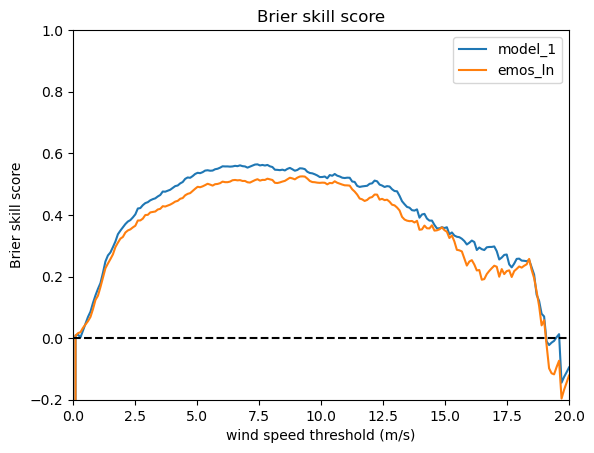

In [13]:
values = np.linspace(0, 20, 200)
#ylim = [-0.1, 0.2]
ylim = [-0.2, 1]
make_brier_skill_plot_tf(climatology, models, test_data, values, ylim=ylim)